# 고객 등급 변동변수 - Momentary

In [32]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
# import missingno
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics import accuracy_score

from matplotlib import font_manager, rc
# font_path = "dataset/malgun.ttf"
# font_name = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font_name)

In [33]:
# 가을14, 15년도 데이터 전체에 고객마다 라벨값을 추가한 데이터 read
df = pd.read_pickle('dataset/full_data_with_label.pkl')

In [35]:
df

,RECEIPTNO,CUSTNO,PURCHDATE,PURCHTIME,AFFIL,CLASSCODEL,CLASSCODEM,CLASSCODES,STORENO,GENDER,AGEGROUP,RESIDENCE,PURCHAMOUNT,Year,AFFIL_CLASS,spent_less
167386,10972931,00001,2014-10-09,15,C,3,0304,C030404,318,M,60세이상,060,1990,2014,C3,0
167387,10972931,00001,2014-10-09,15,C,7,0701,C070102,318,M,60세이상,060,3980,2014,C7,0
167388,10972931,00001,2014-10-09,15,C,7,0704,C070402,318,M,60세이상,060,8400,2014,C7,0
167389,10972931,00001,2014-10-09,15,C,8,0802,C080201,318,M,60세이상,060,3000,2014,C8,0
170493,10972931,00001,2014-10-09,15,C,1,0101,C010101,318,M,60세이상,060,9900,2014,C1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337949,07296382,19375,2015-11-20,15,B,2,0201,B020102,016,F,25세~29세,049,20000,2015,B2,1
3362190,07297104,19375,2015-11-30,23,B,10,1008,B100802,016,F,25세~29세,049,3450,2015,B10,1
3362191,07297104,19375,2015-11-30,23,B,14,1401,B140102,016,F,25세~29세,049,2980,2015,B14,1
3362192,07297104,19375,2015-11-30,23,B,14,1401,B140103,016,F,25세~29세,049,970,2015,B14,1


In [36]:
# 14,15년으로 데이터 분리
_14 = df[df.Year == 2014]
_15 = df[df.Year == 2015]

In [37]:
# 14년도 고객별 총구매금액
a = _14.groupby('CUSTNO').sum()['PURCHAMOUNT'].sort_values(ascending = False)
a

CUSTNO
14599    1047707230
08994     671246550
17129     349901530
16014     262525910
08079     233695130
            ...    
09550         30500
16726         27230
19325         24000
14967         19900
13309         19900
Name: PURCHAMOUNT, Length: 16773, dtype: int64

In [38]:
# 15년도 고객별 총구매금액
b = _15.groupby('CUSTNO').sum()['PURCHAMOUNT'].sort_values(ascending = False)
b

CUSTNO
15999    755995890
06200    325590201
14599    311005540
07801    274373990
04659    225466875
           ...    
09979        10920
16358        10900
16957         8720
00905         6750
04166         4200
Name: PURCHAMOUNT, Length: 16740, dtype: int64

## 14년, 15년 등급 기준 

In [39]:
# 14년도 15년도 등급 기준. 매출의 상위 0~20% = 5 , 20~40% = 4, 40~60% = 3, 60~80% = 2, 80~100% = 1
# 쉽게말하면 사분위수를 다섯단계로 나눈것
print('<14년도 등급기준금액>')
print(a.quantile(.20))
print(a.quantile(.40))
print(a.quantile(.60))
print(a.quantile(.80))
print()
print('<15년도 등급기준금액>')
print(b.quantile(.20))
print(b.quantile(.40))
print(b.quantile(.60))
print(b.quantile(.80))


<14년도 등급기준금액>
1291073.6
1932640.8000000003
3137262.9999999986
6813300.0

<15년도 등급기준금액>
1232316.8
1890410.0
3119662.4
7080453.6


In [40]:
# 14년데이터 데이터프레임화
a1 = pd.DataFrame(a)

# 14년도 등급 : 14년도 매출의 상위 0~20% = 5 , 20~40% = 4, 40~60% = 3, 60~80% = 2, 80~100% = 1
def rank_14 (x):
    if x <= 1138963.0 : return 1
    elif 1138963< x <= 1707830 : return 2
    elif 1707830< x <= 2714515 : return 3
    elif 2714515< x <= 6031550 : return 4
    elif 6031550< x : return 5

a1['rank_14'] = a1.PURCHAMOUNT.apply(rank_14)

a1

,PURCHAMOUNT,rank_14
CUSTNO,,
14599,1047707230,5
08994,671246550,5
17129,349901530,5
16014,262525910,5
08079,233695130,5
...,...,...
09550,30500,1
16726,27230,1
19325,24000,1


In [41]:
# 15년데이터 데이터프레임화
a2 = pd.DataFrame(b)
# 15년도 등급 : 15년도 매출의 상위 0~20% = 1 , 20~40% = 2, 40~60% = 3, 60~80% = 4, 80~100% = 5
def rank_15 (x):
    if x <= 1114050.2 : return 1
    elif 1114050.2 < x <= 1707506.8 : return 2
    elif 1707506.8 < x <= 2728666.4 : return 3
    elif 2728666.4< x <= 6195531.4 : return 4
    elif 6195531.4< x : return 5

a2['rank_15'] = a2.PURCHAMOUNT.apply(rank_15)

a2

,PURCHAMOUNT,rank_15
CUSTNO,,
15999,755995890,5
06200,325590201,5
14599,311005540,5
07801,274373990,5
04659,225466875,5
...,...,...
09979,10920,1
16358,10900,1
16957,8720,1


In [42]:
# a1.rename(columns = {'PURCHAMOUNT': 'PUR14'},inplace = True)
# a2.rename(columns = {'PURCHAMOUNT': 'PUR15'},inplace = True)

total_rank = pd.concat([a1,a2],axis=1 , join='outer')
total_rank

rank = total_rank[['rank_14','rank_15']]
rank

,rank_14,rank_15
CUSTNO,,
14599,5,5.0
08994,5,4.0
17129,5,5.0
16014,5,5.0
08079,5,5.0
...,...,...
09550,1,3.0
16726,1,3.0
19325,1,1.0


## Nan값 처리

In [43]:
# # 14년도 랭크 Nan값(신규 고객으로인한) 같은 값으로 처리  - 고객의 등급변동이 없다고 처리

# rank.rank_14[(rank.rank_14 != rank.rank_14)&(rank.rank_15 == 5)] = 5 
# rank.rank_14[(rank.rank_14 != rank.rank_14)&(rank.rank_15 == 4)] = 4
# rank.rank_14[(rank.rank_14 != rank.rank_14)&(rank.rank_15 == 3)] = 3
# rank.rank_14[(rank.rank_14 != rank.rank_14)&(rank.rank_15 == 2)] = 2
# rank.rank_14[(rank.rank_14 != rank.rank_14)&(rank.rank_15 == 1)] = 1

# # 15년도 랭크 Nan값 0으로 처리 - 14년의 고객등급은 있고 15년에는 없는 경우 14년 고객등급이 그만큼 줄어들었다고 볼수있다.

# rank.rank_15[rank.rank_15 != rank.rank_15] = 0
# rank.rank_15.isnull().sum()

In [47]:
# 등급의 증감
rank['rank_moving'] = rank.rank_15 - rank.rank_14

# 등급의 변동 - 절대값
rank['|rank_moving|'] = abs(rank.rank_14 - rank.rank_15)

rank

,rank_14,rank_15,rank_moving,|rank_moving|
CUSTNO,,,,
14599,5,5.0,0.0,0.0
08994,5,4.0,-1.0,1.0
17129,5,5.0,0.0,0.0
16014,5,5.0,0.0,0.0
08079,5,5.0,0.0,0.0
...,...,...,...,...
09550,1,3.0,2.0,2.0
16726,1,3.0,2.0,2.0
19325,1,1.0,0.0,0.0


In [ ]:
rank['rank_14'] 

## 고객 등급 - 절대값 분포

0.0    8095
1.0    6497
2.0    1602
3.0     434
4.0     112
Name: |rank_moving|, dtype: int64


<AxesSubplot:xlabel='|rank_moving|', ylabel='count'>

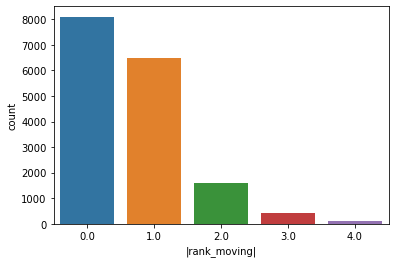

In [45]:
# | rank_moving | 분포 - 절대값
print(rank['|rank_moving|'].value_counts())
sns.countplot('|rank_moving|',data = rank)


## 고객등급 - 증감 분포

 0.0    8095
-1.0    3275
 1.0    3222
-2.0     820
 2.0     782
-3.0     251
 3.0     183
-4.0      72
 4.0      40
Name: rank_moving, dtype: int64


<AxesSubplot:xlabel='rank_moving', ylabel='count'>

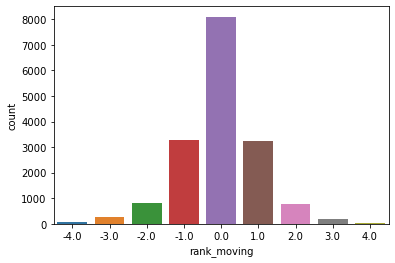

In [46]:
# rank_moving 분포 - 증감
print(rank.rank_moving.value_counts())
sns.countplot('rank_moving',data = rank)
